# Plotting chromosight's output

Chromosight generates tabular text files with loops coordinates and scores. This file can be loaded into your favorite scripting language for visualization. For the purpose of this demonstration, we show how to plot the contact maps with detected coordinates using python, pandas and cooler.

The data shown here was generated with the command:
```bash
chromosight detect data_test/example.cool -m8000 -M50000 -p0.35 detect/
```

In [59]:
import re
import json
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import chromosight.utils.detection as cud

# Load detected patterns' tables
loops = pd.read_csv('detect/loops_out.txt', sep='\t')
borders = pd.read_csv('detect/borders_out.txt', sep='\t')
hairpins = pd.read_csv('detect/hairpins_out.txt', sep='\t')

# Load Hi-C data in cool format
c = cooler.Cooler("../../data_test/example.cool")

## View the whole genome matrix
To plot the whole matrix with patterns, the matrix is extracted from the cool file and columns bin1 and bin2 are used. Those columns contain the genome-wide bin number of pattern coordinates, and matches the whole genome matrix. Plotting the whole genome is straightforward, but likely to take too much memory for larger genomes.

<IPython.core.display.Javascript object>


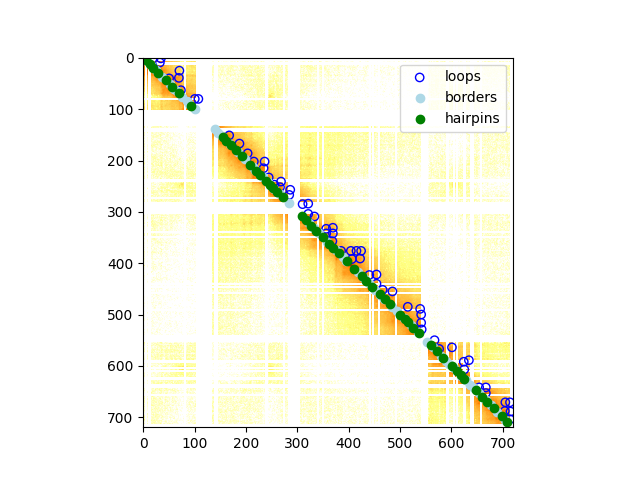

In [60]:
%matplotlib notebook
# Plot the whole matrix
mat = c.matrix(sparse=False, balance=True)[:]
plt.imshow(mat ** 0.2, cmap='afmhot_r')
plt.scatter(loops.bin2, loops.bin1, edgecolors='blue', facecolors='none', label='loops')
plt.scatter(borders.bin2, borders.bin1, c='lightblue', label='borders')
plt.scatter(hairpins.bin2, hairpins.bin1, c='green', label='hairpins')
plt.legend()
plt.show()

## View a matrix region
To reduce the amount of memory required, we can define a region of interest. The corresponding matrix region can be fetched from the cool file using cooler, and patterns falling within that region can be filtered using pandas. Since we want to overlay the patterns on top of the region matrix, the bin1 and bin2 columns should be adjusted to be relative to the region's start instead of the genome.

In [61]:
# Select a region of interest
region = 'chr2:200000-300000'
mat = c.matrix(sparse=False, balance=True).fetch(region)

def subset_region(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom1 == chrom) &
        (df.chrom2 == chrom) &
        (df.start1 >= start) &
        (df.start2 >= start) &
        (df.end1 < end) &
        (df.end2 < end), :
    ]
    return subset

loops_sub = subset_region(loops, region)
borders_sub = subset_region(borders, region)
hairpins_sub = subset_region(hairpins, region)

# Make genome-based bin numbers relative to the region
for df in [loops_sub, borders_sub, hairpins_sub]:
    df.bin1 -= c.extent(region)[0]
    df.bin2 -= c.extent(region)[0]

<IPython.core.display.Javascript object>


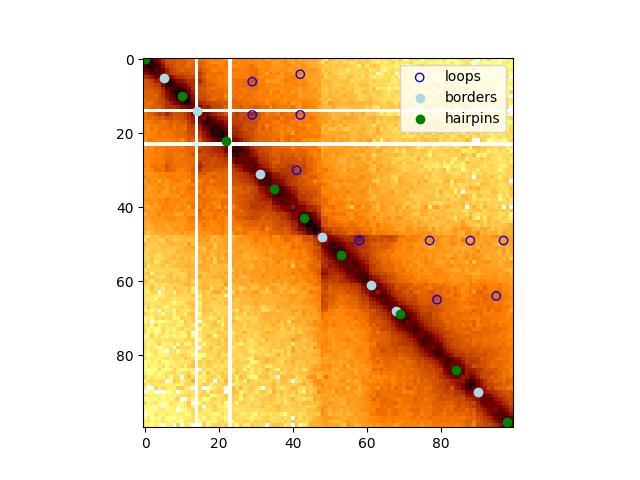

In [62]:
%matplotlib notebook
plt.imshow(mat ** 0.2, cmap='afmhot_r')
plt.scatter(loops_sub.bin2, loops_sub.bin1, edgecolors='blue', facecolors='none', label='loops')
plt.scatter(borders_sub.bin2, borders_sub.bin1, c='lightblue', label='borders')
plt.scatter(hairpins_sub.bin2, hairpins_sub.bin1, c='green', label='hairpins')
plt.legend()
plt.show()

## Plot the distribution of scores
Scores of detected patterns are provided as Pearson correlation coefficient with the template and are stored in the 'score' column of the tabular output. Their distribution can be viewed with regular histogram functions. Since we use a threshold for detection (the `--pearson` option in the command line interface), the score lower end of the distribution will be truncated at this threshold.

Different patterns will have different score distributions and default thresholds.

<IPython.core.display.Javascript object>


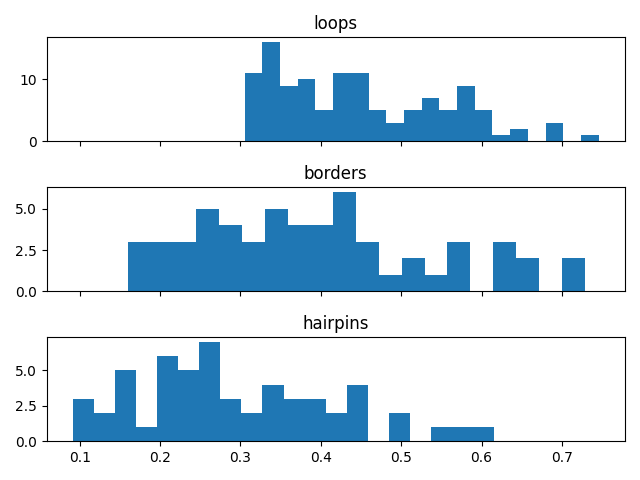

In [55]:
%matplotlib notebook
fig, ax = plt.subplots(3, 1, sharex=True)
for i, (df, pat) in enumerate(zip([loops, borders, hairpins], ['loops', 'borders', 'hairpins'])):
    ax[i].hist(df.score, 20)
    ax[i].set_title(pat)
plt.tight_layout()

## Looking at detected patterns
Windows around detected patterns in the processed matrix are stored in the JSON / npy file when running chromosight's detect or quantify commands. These windows are in the same order as the coordinates in the output table.

In [56]:
# Load input json file into a dictionary
loop_wins = json.load(open('detect/loops_out.json', 'r'))
# Note that keys are string, as required by the JSON format,
# so we convert them to int() for convenience
loop_wins = {int(i): np.array(w) for i, w in loop_wins.items()}
# Make an empty 3D array of shape N_coords x height x width
wins = np.zeros((len(loop_wins.items()), *loop_wins[0].shape))
# Fill the 3D array with windows values
for i, w in loop_wins.items(): wins[i] = w


For example, we can plot windows around detected loops ordered by score:

<IPython.core.display.Javascript object>


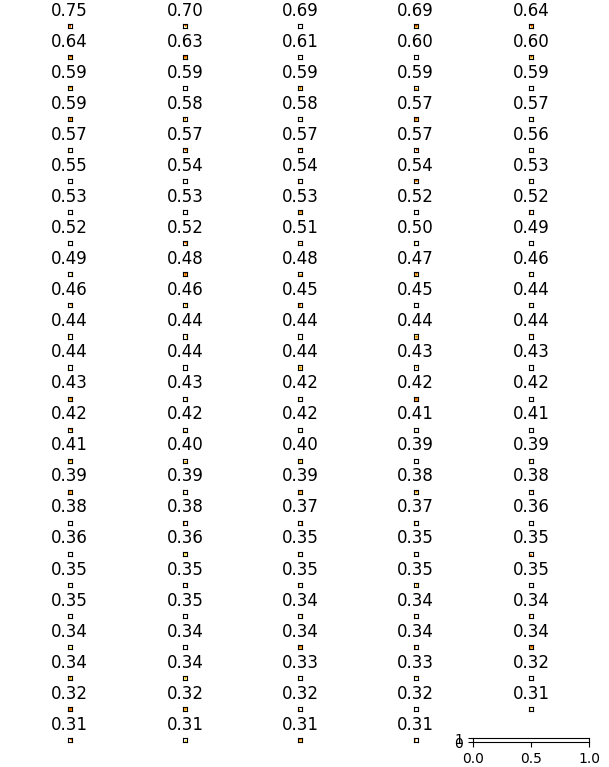

In [57]:
%matplotlib notebook

fig, ax = plt.subplots(len(loop_wins) // 5 + 1, 5, figsize=(8, 12))
for i, n in enumerate(np.argsort(loops.score)[::-1]):
    m, s = np.nanmean(loop_wins[n]), np.nanstd(loop_wins[n])
    ax.flat[i].imshow((loop_wins[n] - m) / s, cmap='afmhot_r', vmax=4)
    ax.flat[i].set_title(f'{loops.score[n]:.2f}')
    ax.flat[i].set_xticks([])
    ax.flat[i].set_yticks([])
plt.tight_layout()

The pileup can also be re-computed from these windows using chromosight's helper function. This is useful to plot the pileup for a subset of the detected patterns, or just to generate the pileup plot with different aesthetics.

<IPython.core.display.Javascript object>


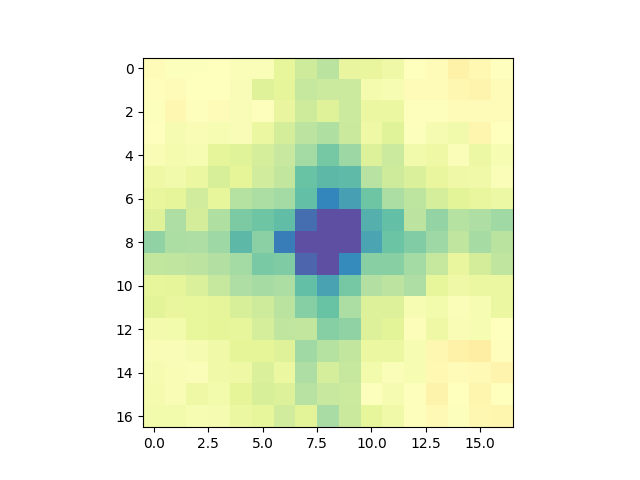

In [58]:
%matplotlib notebook
pileup = cud.pileup_patterns(wins)
plt.imshow(pileup, cmap='Spectral', vmax=1.8, vmin=0)